# ML HW1 | Supervised Learning | Decision Trees
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

## Import Libraries

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import time

## Set directory

In [86]:
directory = "/Users/michaelpecorino/Documents/GitLab/ncaa/"

## Load inputs

In [87]:
ncaa_all = pd.read_csv(directory + "ncaa_all.csv")
train = pd.read_csv(directory + "ncaa_train.csv")
valid = pd.read_csv(directory + "ncaa_valid.csv")
test = pd.read_csv(directory + "ncaa_test.csv")

## Define features and response variable

### Features

In [88]:
features = ["game_win_perc_prop", 
            "game_starters_total_minutes_prop", "game_starters_prop_minutes_prop", "game_player_pts_10plus_prop",
            "game_player_pts_15plus_prop", "game_player_pts_16plus_prop", "game_player_pts_17plus_prop",
            "game_player_pts_18plus_prop", "game_player_pts_19plus_prop", "game_player_pts_20plus_prop",
            "game_player_pts_21plus_prop", "game_player_pts_22plus_prop", "game_player_ast_3plus_prop",
            "game_player_ast_5plus_prop", "game_player_ast_7plus_prop",
            "game_player_orb_1plus_prop", "game_player_orb_2plus_prop", "game_player_orb_3plus_prop",
            "game_player_drb_5plus_prop", "game_player_drb_7plus_prop", "game_player_drb_10plus_prop",
            "game_gs_mean_prop", "game_gs_max_prop", "game_pos_prop", "game_pts_prop", "game_efficiency_prop",
            "game_fg_attempted_prop", "game_ft_attempted_prop", "game_ft_made_prop", "game_stl_prop",
            "game_tov_prop","game_stl_tov_ratio_diff", "game_stl_tov_ratio_prop", "game_blk_prop",
            "game_orb_prop", "game_drb_prop", "game_trb_prop", "game_ast_prop", "game_pf_diff", "game_pf_prop",
            "home_indicator.x", "neutral_indicator"]
ncaa_all_features = ncaa_all[features]
train_features = train[features]
valid_features = valid[features]
train_valid_features = train_features.append(valid_features)
test_features = test[features]

### Response variable

In [89]:
response_variable = "win_indicator"
ncaa_all_response = ncaa_all[response_variable]
train_response = train[response_variable]
valid_response = valid[response_variable]
train_valid_resposnse = train_response.append(valid_response)
test_response = test[response_variable]

## Decision Tree

### Initial model

In [90]:
decision_tree_model = DecisionTreeClassifier(criterion = 'entropy',
                                             splitter = 'best',
                                             max_depth = None,
                                             min_samples_split = 2,
                                             min_samples_leaf = 1,
                                             min_weight_fraction_leaf = 0.0,
                                             max_features = None,
                                             random_state = 28,
                                             max_leaf_nodes = None,
                                             min_impurity_decrease = 0.0,
                                             min_impurity_split = None,
                                             class_weight = None,
                                             ccp_alpha = 0.000001)

decision_tree_model.fit(train_features, train_response) 

print("Decision tree accuracy on training data: ",
      decision_tree_model.score(train_features, train_response))
print("Decision tree accuracy on validation data: ",
      decision_tree_model.score(valid_features, valid_response))

Decision tree accuracy on training data:  0.9951734664411535
Decision tree accuracy on validation data:  0.6450138876444763


### Cost complexity pruning path
https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py

#### Get the CCP

In [91]:
path = decision_tree_model.cost_complexity_pruning_path(train_features, train_response)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

ccp_df = pd.DataFrame(columns = ['ccp_alphas', 'impurities'])
for i in range(0,len(ccp_alphas)):
    ccp_df = ccp_df.append({'ccp_alphas': ccp_alphas[i].round(6),
                            'impurities': impurities[i].round(3)},
                          ignore_index = True)

ccp_df_unique = ccp_df.drop_duplicates()
ccp_alphas = np.array(ccp_df_unique["ccp_alphas"])
impurities = np.array(ccp_df_unique["impurities"])

#### Plot the CCP

Text(0.5, 1.0, 'Total impurity vs effective alpha for training data')

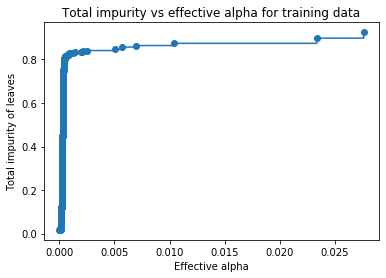

In [92]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker = 'o', drawstyle = "steps-post")
ax.set_xlabel("Effective alpha")
ax.set_ylabel("Total impurity of leaves")
ax.set_title("Total impurity vs effective alpha for training data")

### Train a decision tree for each ccp_alpha and evaluate on cross-validation

In [93]:
folds = set(train['fold'])
folds

{1, 2, 3, 4, 5}

In [26]:
decision_tree_ccps = []
cross_validation_results = pd.DataFrame(columns = ['ccp_alpha', 'fold', 'in_fold_score', 'out_fold_score'])

iter = 0
for ccp_alpha in ccp_alphas:
    iter = iter+1
    
    for fold in folds:
        
        #Debugging
        #ccp_alpha = .0004
        #fold = 1
        
        train_features_in_fold = train[train["fold"] != fold][features]
        train_response_in_fold = train[train["fold"] != fold][response_variable]
        
        test_features_out_fold = train[train["fold"] == fold][features]
        test_response_out_fold = train[train["fold"] == fold][response_variable]

        print("iter:", iter, "ccp_alpha:", ccp_alpha, "impurity:", impurities[iter-1], "for fold:", fold)
        
        decision_tree_ccp = DecisionTreeClassifier(criterion = 'entropy',
                                                   splitter = 'best',
                                                   max_depth = None,
                                                   min_samples_split = 2,
                                                   min_samples_leaf = 1,
                                                   min_weight_fraction_leaf = 0.0,
                                                   max_features = None,
                                                   random_state = 28,
                                                   max_leaf_nodes = None,
                                                   min_impurity_decrease = 0.0,
                                                   min_impurity_split = None,
                                                   class_weight = None,
                                                   ccp_alpha = ccp_alpha)
        
        decision_tree_ccp.fit(train_features_in_fold, train_response_in_fold)
        decision_tree_ccps.append(decision_tree_ccp)
        
        #Evaluate
        in_fold_score = decision_tree_ccp.score(train_features_in_fold, train_response_in_fold)
        out_fold_score = decision_tree_ccp.score(test_features_out_fold, test_response_out_fold)
        
        cross_validation_results = cross_validation_results.append({'ccp_alpha': ccp_alpha,
                                                                    'fold': fold,
                                                                    'in_fold_score': in_fold_score,
                                                                    'out_fold_score': out_fold_score},
                                                                 ignore_index = True)

iter: 1 ccp_alpha: 0.0 impurity: 0.017 for fold: 1
iter: 1 ccp_alpha: 0.0 impurity: 0.017 for fold: 2
iter: 1 ccp_alpha: 0.0 impurity: 0.017 for fold: 3
iter: 1 ccp_alpha: 0.0 impurity: 0.017 for fold: 4
iter: 1 ccp_alpha: 0.0 impurity: 0.017 for fold: 5
iter: 2 ccp_alpha: 2.3e-05 impurity: 0.017 for fold: 1
iter: 2 ccp_alpha: 2.3e-05 impurity: 0.017 for fold: 2
iter: 2 ccp_alpha: 2.3e-05 impurity: 0.017 for fold: 3
iter: 2 ccp_alpha: 2.3e-05 impurity: 0.017 for fold: 4
iter: 2 ccp_alpha: 2.3e-05 impurity: 0.017 for fold: 5
iter: 3 ccp_alpha: 5e-05 impurity: 0.017 for fold: 1
iter: 3 ccp_alpha: 5e-05 impurity: 0.017 for fold: 2
iter: 3 ccp_alpha: 5e-05 impurity: 0.017 for fold: 3
iter: 3 ccp_alpha: 5e-05 impurity: 0.017 for fold: 4
iter: 3 ccp_alpha: 5e-05 impurity: 0.017 for fold: 5
iter: 4 ccp_alpha: 6.7e-05 impurity: 0.017 for fold: 1
iter: 4 ccp_alpha: 6.7e-05 impurity: 0.017 for fold: 2
iter: 4 ccp_alpha: 6.7e-05 impurity: 0.017 for fold: 3
iter: 4 ccp_alpha: 6.7e-05 impurity: 0.0

iter: 30 ccp_alpha: 0.000134 impurity: 0.028 for fold: 3
iter: 30 ccp_alpha: 0.000134 impurity: 0.028 for fold: 4
iter: 30 ccp_alpha: 0.000134 impurity: 0.028 for fold: 5
iter: 31 ccp_alpha: 0.000134 impurity: 0.029 for fold: 1
iter: 31 ccp_alpha: 0.000134 impurity: 0.029 for fold: 2
iter: 31 ccp_alpha: 0.000134 impurity: 0.029 for fold: 3
iter: 31 ccp_alpha: 0.000134 impurity: 0.029 for fold: 4
iter: 31 ccp_alpha: 0.000134 impurity: 0.029 for fold: 5
iter: 32 ccp_alpha: 0.000134 impurity: 0.03 for fold: 1
iter: 32 ccp_alpha: 0.000134 impurity: 0.03 for fold: 2
iter: 32 ccp_alpha: 0.000134 impurity: 0.03 for fold: 3
iter: 32 ccp_alpha: 0.000134 impurity: 0.03 for fold: 4
iter: 32 ccp_alpha: 0.000134 impurity: 0.03 for fold: 5
iter: 33 ccp_alpha: 0.000134 impurity: 0.031 for fold: 1
iter: 33 ccp_alpha: 0.000134 impurity: 0.031 for fold: 2
iter: 33 ccp_alpha: 0.000134 impurity: 0.031 for fold: 3
iter: 33 ccp_alpha: 0.000134 impurity: 0.031 for fold: 4
iter: 33 ccp_alpha: 0.000134 impurit

iter: 59 ccp_alpha: 0.000151 impurity: 0.05 for fold: 3
iter: 59 ccp_alpha: 0.000151 impurity: 0.05 for fold: 4
iter: 59 ccp_alpha: 0.000151 impurity: 0.05 for fold: 5
iter: 60 ccp_alpha: 0.000154 impurity: 0.051 for fold: 1
iter: 60 ccp_alpha: 0.000154 impurity: 0.051 for fold: 2
iter: 60 ccp_alpha: 0.000154 impurity: 0.051 for fold: 3
iter: 60 ccp_alpha: 0.000154 impurity: 0.051 for fold: 4
iter: 60 ccp_alpha: 0.000154 impurity: 0.051 for fold: 5
iter: 61 ccp_alpha: 0.000155 impurity: 0.052 for fold: 1
iter: 61 ccp_alpha: 0.000155 impurity: 0.052 for fold: 2
iter: 61 ccp_alpha: 0.000155 impurity: 0.052 for fold: 3
iter: 61 ccp_alpha: 0.000155 impurity: 0.052 for fold: 4
iter: 61 ccp_alpha: 0.000155 impurity: 0.052 for fold: 5
iter: 62 ccp_alpha: 0.000156 impurity: 0.052 for fold: 1
iter: 62 ccp_alpha: 0.000156 impurity: 0.052 for fold: 2
iter: 62 ccp_alpha: 0.000156 impurity: 0.052 for fold: 3
iter: 62 ccp_alpha: 0.000156 impurity: 0.052 for fold: 4
iter: 62 ccp_alpha: 0.000156 impur

iter: 88 ccp_alpha: 0.000171 impurity: 0.07 for fold: 3
iter: 88 ccp_alpha: 0.000171 impurity: 0.07 for fold: 4
iter: 88 ccp_alpha: 0.000171 impurity: 0.07 for fold: 5
iter: 89 ccp_alpha: 0.000171 impurity: 0.071 for fold: 1
iter: 89 ccp_alpha: 0.000171 impurity: 0.071 for fold: 2
iter: 89 ccp_alpha: 0.000171 impurity: 0.071 for fold: 3
iter: 89 ccp_alpha: 0.000171 impurity: 0.071 for fold: 4
iter: 89 ccp_alpha: 0.000171 impurity: 0.071 for fold: 5
iter: 90 ccp_alpha: 0.000171 impurity: 0.072 for fold: 1
iter: 90 ccp_alpha: 0.000171 impurity: 0.072 for fold: 2
iter: 90 ccp_alpha: 0.000171 impurity: 0.072 for fold: 3
iter: 90 ccp_alpha: 0.000171 impurity: 0.072 for fold: 4
iter: 90 ccp_alpha: 0.000171 impurity: 0.072 for fold: 5
iter: 91 ccp_alpha: 0.000172 impurity: 0.072 for fold: 1
iter: 91 ccp_alpha: 0.000172 impurity: 0.072 for fold: 2
iter: 91 ccp_alpha: 0.000172 impurity: 0.072 for fold: 3
iter: 91 ccp_alpha: 0.000172 impurity: 0.072 for fold: 4
iter: 91 ccp_alpha: 0.000172 impur

iter: 117 ccp_alpha: 0.000186 impurity: 0.089 for fold: 1
iter: 117 ccp_alpha: 0.000186 impurity: 0.089 for fold: 2
iter: 117 ccp_alpha: 0.000186 impurity: 0.089 for fold: 3
iter: 117 ccp_alpha: 0.000186 impurity: 0.089 for fold: 4
iter: 117 ccp_alpha: 0.000186 impurity: 0.089 for fold: 5
iter: 118 ccp_alpha: 0.000187 impurity: 0.089 for fold: 1
iter: 118 ccp_alpha: 0.000187 impurity: 0.089 for fold: 2
iter: 118 ccp_alpha: 0.000187 impurity: 0.089 for fold: 3
iter: 118 ccp_alpha: 0.000187 impurity: 0.089 for fold: 4
iter: 118 ccp_alpha: 0.000187 impurity: 0.089 for fold: 5
iter: 119 ccp_alpha: 0.000187 impurity: 0.09 for fold: 1
iter: 119 ccp_alpha: 0.000187 impurity: 0.09 for fold: 2
iter: 119 ccp_alpha: 0.000187 impurity: 0.09 for fold: 3
iter: 119 ccp_alpha: 0.000187 impurity: 0.09 for fold: 4
iter: 119 ccp_alpha: 0.000187 impurity: 0.09 for fold: 5
iter: 120 ccp_alpha: 0.000187 impurity: 0.091 for fold: 1
iter: 120 ccp_alpha: 0.000187 impurity: 0.091 for fold: 2
iter: 120 ccp_alpha

iter: 145 ccp_alpha: 0.000199 impurity: 0.11 for fold: 3
iter: 145 ccp_alpha: 0.000199 impurity: 0.11 for fold: 4
iter: 145 ccp_alpha: 0.000199 impurity: 0.11 for fold: 5
iter: 146 ccp_alpha: 0.000199 impurity: 0.111 for fold: 1
iter: 146 ccp_alpha: 0.000199 impurity: 0.111 for fold: 2
iter: 146 ccp_alpha: 0.000199 impurity: 0.111 for fold: 3
iter: 146 ccp_alpha: 0.000199 impurity: 0.111 for fold: 4
iter: 146 ccp_alpha: 0.000199 impurity: 0.111 for fold: 5
iter: 147 ccp_alpha: 0.000199 impurity: 0.112 for fold: 1
iter: 147 ccp_alpha: 0.000199 impurity: 0.112 for fold: 2
iter: 147 ccp_alpha: 0.000199 impurity: 0.112 for fold: 3
iter: 147 ccp_alpha: 0.000199 impurity: 0.112 for fold: 4
iter: 147 ccp_alpha: 0.000199 impurity: 0.112 for fold: 5
iter: 148 ccp_alpha: 0.000199 impurity: 0.113 for fold: 1
iter: 148 ccp_alpha: 0.000199 impurity: 0.113 for fold: 2
iter: 148 ccp_alpha: 0.000199 impurity: 0.113 for fold: 3
iter: 148 ccp_alpha: 0.000199 impurity: 0.113 for fold: 4
iter: 148 ccp_alp

iter: 174 ccp_alpha: 0.000208 impurity: 0.133 for fold: 1
iter: 174 ccp_alpha: 0.000208 impurity: 0.133 for fold: 2
iter: 174 ccp_alpha: 0.000208 impurity: 0.133 for fold: 3
iter: 174 ccp_alpha: 0.000208 impurity: 0.133 for fold: 4
iter: 174 ccp_alpha: 0.000208 impurity: 0.133 for fold: 5
iter: 175 ccp_alpha: 0.000209 impurity: 0.133 for fold: 1
iter: 175 ccp_alpha: 0.000209 impurity: 0.133 for fold: 2
iter: 175 ccp_alpha: 0.000209 impurity: 0.133 for fold: 3
iter: 175 ccp_alpha: 0.000209 impurity: 0.133 for fold: 4
iter: 175 ccp_alpha: 0.000209 impurity: 0.133 for fold: 5
iter: 176 ccp_alpha: 0.000209 impurity: 0.134 for fold: 1
iter: 176 ccp_alpha: 0.000209 impurity: 0.134 for fold: 2
iter: 176 ccp_alpha: 0.000209 impurity: 0.134 for fold: 3
iter: 176 ccp_alpha: 0.000209 impurity: 0.134 for fold: 4
iter: 176 ccp_alpha: 0.000209 impurity: 0.134 for fold: 5
iter: 177 ccp_alpha: 0.00021 impurity: 0.134 for fold: 1
iter: 177 ccp_alpha: 0.00021 impurity: 0.134 for fold: 2
iter: 177 ccp_al

iter: 202 ccp_alpha: 0.000221 impurity: 0.155 for fold: 3
iter: 202 ccp_alpha: 0.000221 impurity: 0.155 for fold: 4
iter: 202 ccp_alpha: 0.000221 impurity: 0.155 for fold: 5
iter: 203 ccp_alpha: 0.000222 impurity: 0.155 for fold: 1
iter: 203 ccp_alpha: 0.000222 impurity: 0.155 for fold: 2
iter: 203 ccp_alpha: 0.000222 impurity: 0.155 for fold: 3
iter: 203 ccp_alpha: 0.000222 impurity: 0.155 for fold: 4
iter: 203 ccp_alpha: 0.000222 impurity: 0.155 for fold: 5
iter: 204 ccp_alpha: 0.000222 impurity: 0.156 for fold: 1
iter: 204 ccp_alpha: 0.000222 impurity: 0.156 for fold: 2
iter: 204 ccp_alpha: 0.000222 impurity: 0.156 for fold: 3
iter: 204 ccp_alpha: 0.000222 impurity: 0.156 for fold: 4
iter: 204 ccp_alpha: 0.000222 impurity: 0.156 for fold: 5
iter: 205 ccp_alpha: 0.000223 impurity: 0.157 for fold: 1
iter: 205 ccp_alpha: 0.000223 impurity: 0.157 for fold: 2
iter: 205 ccp_alpha: 0.000223 impurity: 0.157 for fold: 3
iter: 205 ccp_alpha: 0.000223 impurity: 0.157 for fold: 4
iter: 205 ccp_

iter: 230 ccp_alpha: 0.000228 impurity: 0.18 for fold: 5
iter: 231 ccp_alpha: 0.000228 impurity: 0.181 for fold: 1
iter: 231 ccp_alpha: 0.000228 impurity: 0.181 for fold: 2
iter: 231 ccp_alpha: 0.000228 impurity: 0.181 for fold: 3
iter: 231 ccp_alpha: 0.000228 impurity: 0.181 for fold: 4
iter: 231 ccp_alpha: 0.000228 impurity: 0.181 for fold: 5
iter: 232 ccp_alpha: 0.000228 impurity: 0.182 for fold: 1
iter: 232 ccp_alpha: 0.000228 impurity: 0.182 for fold: 2
iter: 232 ccp_alpha: 0.000228 impurity: 0.182 for fold: 3
iter: 232 ccp_alpha: 0.000228 impurity: 0.182 for fold: 4
iter: 232 ccp_alpha: 0.000228 impurity: 0.182 for fold: 5
iter: 233 ccp_alpha: 0.000228 impurity: 0.183 for fold: 1
iter: 233 ccp_alpha: 0.000228 impurity: 0.183 for fold: 2
iter: 233 ccp_alpha: 0.000228 impurity: 0.183 for fold: 3
iter: 233 ccp_alpha: 0.000228 impurity: 0.183 for fold: 4
iter: 233 ccp_alpha: 0.000228 impurity: 0.183 for fold: 5
iter: 234 ccp_alpha: 0.000229 impurity: 0.183 for fold: 1
iter: 234 ccp_a

iter: 259 ccp_alpha: 0.000235 impurity: 0.203 for fold: 3
iter: 259 ccp_alpha: 0.000235 impurity: 0.203 for fold: 4
iter: 259 ccp_alpha: 0.000235 impurity: 0.203 for fold: 5
iter: 260 ccp_alpha: 0.000236 impurity: 0.204 for fold: 1
iter: 260 ccp_alpha: 0.000236 impurity: 0.204 for fold: 2
iter: 260 ccp_alpha: 0.000236 impurity: 0.204 for fold: 3
iter: 260 ccp_alpha: 0.000236 impurity: 0.204 for fold: 4
iter: 260 ccp_alpha: 0.000236 impurity: 0.204 for fold: 5
iter: 261 ccp_alpha: 0.000236 impurity: 0.205 for fold: 1
iter: 261 ccp_alpha: 0.000236 impurity: 0.205 for fold: 2
iter: 261 ccp_alpha: 0.000236 impurity: 0.205 for fold: 3
iter: 261 ccp_alpha: 0.000236 impurity: 0.205 for fold: 4
iter: 261 ccp_alpha: 0.000236 impurity: 0.205 for fold: 5
iter: 262 ccp_alpha: 0.000236 impurity: 0.206 for fold: 1
iter: 262 ccp_alpha: 0.000236 impurity: 0.206 for fold: 2
iter: 262 ccp_alpha: 0.000236 impurity: 0.206 for fold: 3
iter: 262 ccp_alpha: 0.000236 impurity: 0.206 for fold: 4
iter: 262 ccp_

iter: 287 ccp_alpha: 0.000243 impurity: 0.23 for fold: 5
iter: 288 ccp_alpha: 0.000243 impurity: 0.231 for fold: 1
iter: 288 ccp_alpha: 0.000243 impurity: 0.231 for fold: 2
iter: 288 ccp_alpha: 0.000243 impurity: 0.231 for fold: 3
iter: 288 ccp_alpha: 0.000243 impurity: 0.231 for fold: 4
iter: 288 ccp_alpha: 0.000243 impurity: 0.231 for fold: 5
iter: 289 ccp_alpha: 0.000243 impurity: 0.232 for fold: 1
iter: 289 ccp_alpha: 0.000243 impurity: 0.232 for fold: 2
iter: 289 ccp_alpha: 0.000243 impurity: 0.232 for fold: 3
iter: 289 ccp_alpha: 0.000243 impurity: 0.232 for fold: 4
iter: 289 ccp_alpha: 0.000243 impurity: 0.232 for fold: 5
iter: 290 ccp_alpha: 0.000244 impurity: 0.232 for fold: 1
iter: 290 ccp_alpha: 0.000244 impurity: 0.232 for fold: 2
iter: 290 ccp_alpha: 0.000244 impurity: 0.232 for fold: 3
iter: 290 ccp_alpha: 0.000244 impurity: 0.232 for fold: 4
iter: 290 ccp_alpha: 0.000244 impurity: 0.232 for fold: 5
iter: 291 ccp_alpha: 0.000244 impurity: 0.233 for fold: 1
iter: 291 ccp_a

iter: 316 ccp_alpha: 0.000249 impurity: 0.255 for fold: 2
iter: 316 ccp_alpha: 0.000249 impurity: 0.255 for fold: 3
iter: 316 ccp_alpha: 0.000249 impurity: 0.255 for fold: 4
iter: 316 ccp_alpha: 0.000249 impurity: 0.255 for fold: 5
iter: 317 ccp_alpha: 0.000249 impurity: 0.256 for fold: 1
iter: 317 ccp_alpha: 0.000249 impurity: 0.256 for fold: 2
iter: 317 ccp_alpha: 0.000249 impurity: 0.256 for fold: 3
iter: 317 ccp_alpha: 0.000249 impurity: 0.256 for fold: 4
iter: 317 ccp_alpha: 0.000249 impurity: 0.256 for fold: 5
iter: 318 ccp_alpha: 0.000249 impurity: 0.257 for fold: 1
iter: 318 ccp_alpha: 0.000249 impurity: 0.257 for fold: 2
iter: 318 ccp_alpha: 0.000249 impurity: 0.257 for fold: 3
iter: 318 ccp_alpha: 0.000249 impurity: 0.257 for fold: 4
iter: 318 ccp_alpha: 0.000249 impurity: 0.257 for fold: 5
iter: 319 ccp_alpha: 0.000249 impurity: 0.258 for fold: 1
iter: 319 ccp_alpha: 0.000249 impurity: 0.258 for fold: 2
iter: 319 ccp_alpha: 0.000249 impurity: 0.258 for fold: 3
iter: 319 ccp_

iter: 344 ccp_alpha: 0.000255 impurity: 0.28 for fold: 5
iter: 345 ccp_alpha: 0.000255 impurity: 0.281 for fold: 1
iter: 345 ccp_alpha: 0.000255 impurity: 0.281 for fold: 2
iter: 345 ccp_alpha: 0.000255 impurity: 0.281 for fold: 3
iter: 345 ccp_alpha: 0.000255 impurity: 0.281 for fold: 4
iter: 345 ccp_alpha: 0.000255 impurity: 0.281 for fold: 5
iter: 346 ccp_alpha: 0.000256 impurity: 0.281 for fold: 1
iter: 346 ccp_alpha: 0.000256 impurity: 0.281 for fold: 2
iter: 346 ccp_alpha: 0.000256 impurity: 0.281 for fold: 3
iter: 346 ccp_alpha: 0.000256 impurity: 0.281 for fold: 4
iter: 346 ccp_alpha: 0.000256 impurity: 0.281 for fold: 5
iter: 347 ccp_alpha: 0.000256 impurity: 0.283 for fold: 1
iter: 347 ccp_alpha: 0.000256 impurity: 0.283 for fold: 2
iter: 347 ccp_alpha: 0.000256 impurity: 0.283 for fold: 3
iter: 347 ccp_alpha: 0.000256 impurity: 0.283 for fold: 4
iter: 347 ccp_alpha: 0.000256 impurity: 0.283 for fold: 5
iter: 348 ccp_alpha: 0.000256 impurity: 0.284 for fold: 1
iter: 348 ccp_a

iter: 373 ccp_alpha: 0.000262 impurity: 0.313 for fold: 2
iter: 373 ccp_alpha: 0.000262 impurity: 0.313 for fold: 3
iter: 373 ccp_alpha: 0.000262 impurity: 0.313 for fold: 4
iter: 373 ccp_alpha: 0.000262 impurity: 0.313 for fold: 5
iter: 374 ccp_alpha: 0.000262 impurity: 0.314 for fold: 1
iter: 374 ccp_alpha: 0.000262 impurity: 0.314 for fold: 2
iter: 374 ccp_alpha: 0.000262 impurity: 0.314 for fold: 3
iter: 374 ccp_alpha: 0.000262 impurity: 0.314 for fold: 4
iter: 374 ccp_alpha: 0.000262 impurity: 0.314 for fold: 5
iter: 375 ccp_alpha: 0.000262 impurity: 0.315 for fold: 1
iter: 375 ccp_alpha: 0.000262 impurity: 0.315 for fold: 2
iter: 375 ccp_alpha: 0.000262 impurity: 0.315 for fold: 3
iter: 375 ccp_alpha: 0.000262 impurity: 0.315 for fold: 4
iter: 375 ccp_alpha: 0.000262 impurity: 0.315 for fold: 5
iter: 376 ccp_alpha: 0.000262 impurity: 0.316 for fold: 1
iter: 376 ccp_alpha: 0.000262 impurity: 0.316 for fold: 2
iter: 376 ccp_alpha: 0.000262 impurity: 0.316 for fold: 3
iter: 376 ccp_

iter: 401 ccp_alpha: 0.000267 impurity: 0.349 for fold: 4
iter: 401 ccp_alpha: 0.000267 impurity: 0.349 for fold: 5
iter: 402 ccp_alpha: 0.000267 impurity: 0.35 for fold: 1
iter: 402 ccp_alpha: 0.000267 impurity: 0.35 for fold: 2
iter: 402 ccp_alpha: 0.000267 impurity: 0.35 for fold: 3
iter: 402 ccp_alpha: 0.000267 impurity: 0.35 for fold: 4
iter: 402 ccp_alpha: 0.000267 impurity: 0.35 for fold: 5
iter: 403 ccp_alpha: 0.000267 impurity: 0.351 for fold: 1
iter: 403 ccp_alpha: 0.000267 impurity: 0.351 for fold: 2
iter: 403 ccp_alpha: 0.000267 impurity: 0.351 for fold: 3
iter: 403 ccp_alpha: 0.000267 impurity: 0.351 for fold: 4
iter: 403 ccp_alpha: 0.000267 impurity: 0.351 for fold: 5
iter: 404 ccp_alpha: 0.000267 impurity: 0.352 for fold: 1
iter: 404 ccp_alpha: 0.000267 impurity: 0.352 for fold: 2
iter: 404 ccp_alpha: 0.000267 impurity: 0.352 for fold: 3
iter: 404 ccp_alpha: 0.000267 impurity: 0.352 for fold: 4
iter: 404 ccp_alpha: 0.000267 impurity: 0.352 for fold: 5
iter: 405 ccp_alpha

iter: 430 ccp_alpha: 0.000274 impurity: 0.376 for fold: 1
iter: 430 ccp_alpha: 0.000274 impurity: 0.376 for fold: 2
iter: 430 ccp_alpha: 0.000274 impurity: 0.376 for fold: 3
iter: 430 ccp_alpha: 0.000274 impurity: 0.376 for fold: 4
iter: 430 ccp_alpha: 0.000274 impurity: 0.376 for fold: 5
iter: 431 ccp_alpha: 0.000275 impurity: 0.376 for fold: 1
iter: 431 ccp_alpha: 0.000275 impurity: 0.376 for fold: 2
iter: 431 ccp_alpha: 0.000275 impurity: 0.376 for fold: 3
iter: 431 ccp_alpha: 0.000275 impurity: 0.376 for fold: 4
iter: 431 ccp_alpha: 0.000275 impurity: 0.376 for fold: 5
iter: 432 ccp_alpha: 0.000275 impurity: 0.377 for fold: 1
iter: 432 ccp_alpha: 0.000275 impurity: 0.377 for fold: 2
iter: 432 ccp_alpha: 0.000275 impurity: 0.377 for fold: 3
iter: 432 ccp_alpha: 0.000275 impurity: 0.377 for fold: 4
iter: 432 ccp_alpha: 0.000275 impurity: 0.377 for fold: 5
iter: 433 ccp_alpha: 0.000275 impurity: 0.379 for fold: 1
iter: 433 ccp_alpha: 0.000275 impurity: 0.379 for fold: 2
iter: 433 ccp_

iter: 458 ccp_alpha: 0.000282 impurity: 0.407 for fold: 3
iter: 458 ccp_alpha: 0.000282 impurity: 0.407 for fold: 4
iter: 458 ccp_alpha: 0.000282 impurity: 0.407 for fold: 5
iter: 459 ccp_alpha: 0.000282 impurity: 0.408 for fold: 1
iter: 459 ccp_alpha: 0.000282 impurity: 0.408 for fold: 2
iter: 459 ccp_alpha: 0.000282 impurity: 0.408 for fold: 3
iter: 459 ccp_alpha: 0.000282 impurity: 0.408 for fold: 4
iter: 459 ccp_alpha: 0.000282 impurity: 0.408 for fold: 5
iter: 460 ccp_alpha: 0.000282 impurity: 0.411 for fold: 1
iter: 460 ccp_alpha: 0.000282 impurity: 0.411 for fold: 2
iter: 460 ccp_alpha: 0.000282 impurity: 0.411 for fold: 3
iter: 460 ccp_alpha: 0.000282 impurity: 0.411 for fold: 4
iter: 460 ccp_alpha: 0.000282 impurity: 0.411 for fold: 5
iter: 461 ccp_alpha: 0.000282 impurity: 0.413 for fold: 1
iter: 461 ccp_alpha: 0.000282 impurity: 0.413 for fold: 2
iter: 461 ccp_alpha: 0.000282 impurity: 0.413 for fold: 3
iter: 461 ccp_alpha: 0.000282 impurity: 0.413 for fold: 4
iter: 461 ccp_

iter: 486 ccp_alpha: 0.000288 impurity: 0.443 for fold: 5
iter: 487 ccp_alpha: 0.000288 impurity: 0.444 for fold: 1
iter: 487 ccp_alpha: 0.000288 impurity: 0.444 for fold: 2
iter: 487 ccp_alpha: 0.000288 impurity: 0.444 for fold: 3
iter: 487 ccp_alpha: 0.000288 impurity: 0.444 for fold: 4
iter: 487 ccp_alpha: 0.000288 impurity: 0.444 for fold: 5
iter: 488 ccp_alpha: 0.000289 impurity: 0.444 for fold: 1
iter: 488 ccp_alpha: 0.000289 impurity: 0.444 for fold: 2
iter: 488 ccp_alpha: 0.000289 impurity: 0.444 for fold: 3
iter: 488 ccp_alpha: 0.000289 impurity: 0.444 for fold: 4
iter: 488 ccp_alpha: 0.000289 impurity: 0.444 for fold: 5
iter: 489 ccp_alpha: 0.000289 impurity: 0.445 for fold: 1
iter: 489 ccp_alpha: 0.000289 impurity: 0.445 for fold: 2
iter: 489 ccp_alpha: 0.000289 impurity: 0.445 for fold: 3
iter: 489 ccp_alpha: 0.000289 impurity: 0.445 for fold: 4
iter: 489 ccp_alpha: 0.000289 impurity: 0.445 for fold: 5
iter: 490 ccp_alpha: 0.000289 impurity: 0.446 for fold: 1
iter: 490 ccp_

iter: 515 ccp_alpha: 0.000296 impurity: 0.485 for fold: 2
iter: 515 ccp_alpha: 0.000296 impurity: 0.485 for fold: 3
iter: 515 ccp_alpha: 0.000296 impurity: 0.485 for fold: 4
iter: 515 ccp_alpha: 0.000296 impurity: 0.485 for fold: 5
iter: 516 ccp_alpha: 0.000296 impurity: 0.486 for fold: 1
iter: 516 ccp_alpha: 0.000296 impurity: 0.486 for fold: 2
iter: 516 ccp_alpha: 0.000296 impurity: 0.486 for fold: 3
iter: 516 ccp_alpha: 0.000296 impurity: 0.486 for fold: 4
iter: 516 ccp_alpha: 0.000296 impurity: 0.486 for fold: 5
iter: 517 ccp_alpha: 0.000297 impurity: 0.486 for fold: 1
iter: 517 ccp_alpha: 0.000297 impurity: 0.486 for fold: 2
iter: 517 ccp_alpha: 0.000297 impurity: 0.486 for fold: 3
iter: 517 ccp_alpha: 0.000297 impurity: 0.486 for fold: 4
iter: 517 ccp_alpha: 0.000297 impurity: 0.486 for fold: 5
iter: 518 ccp_alpha: 0.000297 impurity: 0.487 for fold: 1
iter: 518 ccp_alpha: 0.000297 impurity: 0.487 for fold: 2
iter: 518 ccp_alpha: 0.000297 impurity: 0.487 for fold: 3
iter: 518 ccp_

iter: 543 ccp_alpha: 0.000304 impurity: 0.523 for fold: 5
iter: 544 ccp_alpha: 0.000304 impurity: 0.524 for fold: 1
iter: 544 ccp_alpha: 0.000304 impurity: 0.524 for fold: 2
iter: 544 ccp_alpha: 0.000304 impurity: 0.524 for fold: 3
iter: 544 ccp_alpha: 0.000304 impurity: 0.524 for fold: 4
iter: 544 ccp_alpha: 0.000304 impurity: 0.524 for fold: 5
iter: 545 ccp_alpha: 0.000305 impurity: 0.525 for fold: 1
iter: 545 ccp_alpha: 0.000305 impurity: 0.525 for fold: 2
iter: 545 ccp_alpha: 0.000305 impurity: 0.525 for fold: 3
iter: 545 ccp_alpha: 0.000305 impurity: 0.525 for fold: 4
iter: 545 ccp_alpha: 0.000305 impurity: 0.525 for fold: 5
iter: 546 ccp_alpha: 0.000305 impurity: 0.529 for fold: 1
iter: 546 ccp_alpha: 0.000305 impurity: 0.529 for fold: 2
iter: 546 ccp_alpha: 0.000305 impurity: 0.529 for fold: 3
iter: 546 ccp_alpha: 0.000305 impurity: 0.529 for fold: 4
iter: 546 ccp_alpha: 0.000305 impurity: 0.529 for fold: 5
iter: 547 ccp_alpha: 0.000305 impurity: 0.53 for fold: 1
iter: 547 ccp_a

iter: 572 ccp_alpha: 0.000313 impurity: 0.573 for fold: 2
iter: 572 ccp_alpha: 0.000313 impurity: 0.573 for fold: 3
iter: 572 ccp_alpha: 0.000313 impurity: 0.573 for fold: 4
iter: 572 ccp_alpha: 0.000313 impurity: 0.573 for fold: 5
iter: 573 ccp_alpha: 0.000314 impurity: 0.575 for fold: 1
iter: 573 ccp_alpha: 0.000314 impurity: 0.575 for fold: 2
iter: 573 ccp_alpha: 0.000314 impurity: 0.575 for fold: 3
iter: 573 ccp_alpha: 0.000314 impurity: 0.575 for fold: 4
iter: 573 ccp_alpha: 0.000314 impurity: 0.575 for fold: 5
iter: 574 ccp_alpha: 0.000314 impurity: 0.577 for fold: 1
iter: 574 ccp_alpha: 0.000314 impurity: 0.577 for fold: 2
iter: 574 ccp_alpha: 0.000314 impurity: 0.577 for fold: 3
iter: 574 ccp_alpha: 0.000314 impurity: 0.577 for fold: 4
iter: 574 ccp_alpha: 0.000314 impurity: 0.577 for fold: 5
iter: 575 ccp_alpha: 0.000314 impurity: 0.578 for fold: 1
iter: 575 ccp_alpha: 0.000314 impurity: 0.578 for fold: 2
iter: 575 ccp_alpha: 0.000314 impurity: 0.578 for fold: 3
iter: 575 ccp_

iter: 600 ccp_alpha: 0.000323 impurity: 0.62 for fold: 4
iter: 600 ccp_alpha: 0.000323 impurity: 0.62 for fold: 5
iter: 601 ccp_alpha: 0.000324 impurity: 0.622 for fold: 1
iter: 601 ccp_alpha: 0.000324 impurity: 0.622 for fold: 2
iter: 601 ccp_alpha: 0.000324 impurity: 0.622 for fold: 3
iter: 601 ccp_alpha: 0.000324 impurity: 0.622 for fold: 4
iter: 601 ccp_alpha: 0.000324 impurity: 0.622 for fold: 5
iter: 602 ccp_alpha: 0.000325 impurity: 0.622 for fold: 1
iter: 602 ccp_alpha: 0.000325 impurity: 0.622 for fold: 2
iter: 602 ccp_alpha: 0.000325 impurity: 0.622 for fold: 3
iter: 602 ccp_alpha: 0.000325 impurity: 0.622 for fold: 4
iter: 602 ccp_alpha: 0.000325 impurity: 0.622 for fold: 5
iter: 603 ccp_alpha: 0.000325 impurity: 0.623 for fold: 1
iter: 603 ccp_alpha: 0.000325 impurity: 0.623 for fold: 2
iter: 603 ccp_alpha: 0.000325 impurity: 0.623 for fold: 3
iter: 603 ccp_alpha: 0.000325 impurity: 0.623 for fold: 4
iter: 603 ccp_alpha: 0.000325 impurity: 0.623 for fold: 5
iter: 604 ccp_al

iter: 629 ccp_alpha: 0.000336 impurity: 0.67 for fold: 1
iter: 629 ccp_alpha: 0.000336 impurity: 0.67 for fold: 2
iter: 629 ccp_alpha: 0.000336 impurity: 0.67 for fold: 3
iter: 629 ccp_alpha: 0.000336 impurity: 0.67 for fold: 4
iter: 629 ccp_alpha: 0.000336 impurity: 0.67 for fold: 5
iter: 630 ccp_alpha: 0.000337 impurity: 0.672 for fold: 1
iter: 630 ccp_alpha: 0.000337 impurity: 0.672 for fold: 2
iter: 630 ccp_alpha: 0.000337 impurity: 0.672 for fold: 3
iter: 630 ccp_alpha: 0.000337 impurity: 0.672 for fold: 4
iter: 630 ccp_alpha: 0.000337 impurity: 0.672 for fold: 5
iter: 631 ccp_alpha: 0.000337 impurity: 0.673 for fold: 1
iter: 631 ccp_alpha: 0.000337 impurity: 0.673 for fold: 2
iter: 631 ccp_alpha: 0.000337 impurity: 0.673 for fold: 3
iter: 631 ccp_alpha: 0.000337 impurity: 0.673 for fold: 4
iter: 631 ccp_alpha: 0.000337 impurity: 0.673 for fold: 5
iter: 632 ccp_alpha: 0.000338 impurity: 0.676 for fold: 1
iter: 632 ccp_alpha: 0.000338 impurity: 0.676 for fold: 2
iter: 632 ccp_alpha

iter: 657 ccp_alpha: 0.000352 impurity: 0.704 for fold: 4
iter: 657 ccp_alpha: 0.000352 impurity: 0.704 for fold: 5
iter: 658 ccp_alpha: 0.000353 impurity: 0.706 for fold: 1
iter: 658 ccp_alpha: 0.000353 impurity: 0.706 for fold: 2
iter: 658 ccp_alpha: 0.000353 impurity: 0.706 for fold: 3
iter: 658 ccp_alpha: 0.000353 impurity: 0.706 for fold: 4
iter: 658 ccp_alpha: 0.000353 impurity: 0.706 for fold: 5
iter: 659 ccp_alpha: 0.000353 impurity: 0.707 for fold: 1
iter: 659 ccp_alpha: 0.000353 impurity: 0.707 for fold: 2
iter: 659 ccp_alpha: 0.000353 impurity: 0.707 for fold: 3
iter: 659 ccp_alpha: 0.000353 impurity: 0.707 for fold: 4
iter: 659 ccp_alpha: 0.000353 impurity: 0.707 for fold: 5
iter: 660 ccp_alpha: 0.000354 impurity: 0.707 for fold: 1
iter: 660 ccp_alpha: 0.000354 impurity: 0.707 for fold: 2
iter: 660 ccp_alpha: 0.000354 impurity: 0.707 for fold: 3
iter: 660 ccp_alpha: 0.000354 impurity: 0.707 for fold: 4
iter: 660 ccp_alpha: 0.000354 impurity: 0.707 for fold: 5
iter: 661 ccp_

iter: 686 ccp_alpha: 0.000374 impurity: 0.742 for fold: 1
iter: 686 ccp_alpha: 0.000374 impurity: 0.742 for fold: 2
iter: 686 ccp_alpha: 0.000374 impurity: 0.742 for fold: 3
iter: 686 ccp_alpha: 0.000374 impurity: 0.742 for fold: 4
iter: 686 ccp_alpha: 0.000374 impurity: 0.742 for fold: 5
iter: 687 ccp_alpha: 0.000374 impurity: 0.743 for fold: 1
iter: 687 ccp_alpha: 0.000374 impurity: 0.743 for fold: 2
iter: 687 ccp_alpha: 0.000374 impurity: 0.743 for fold: 3
iter: 687 ccp_alpha: 0.000374 impurity: 0.743 for fold: 4
iter: 687 ccp_alpha: 0.000374 impurity: 0.743 for fold: 5
iter: 688 ccp_alpha: 0.000375 impurity: 0.745 for fold: 1
iter: 688 ccp_alpha: 0.000375 impurity: 0.745 for fold: 2
iter: 688 ccp_alpha: 0.000375 impurity: 0.745 for fold: 3
iter: 688 ccp_alpha: 0.000375 impurity: 0.745 for fold: 4
iter: 688 ccp_alpha: 0.000375 impurity: 0.745 for fold: 5
iter: 689 ccp_alpha: 0.000375 impurity: 0.746 for fold: 1
iter: 689 ccp_alpha: 0.000375 impurity: 0.746 for fold: 2
iter: 689 ccp_

iter: 714 ccp_alpha: 0.000406 impurity: 0.78 for fold: 3
iter: 714 ccp_alpha: 0.000406 impurity: 0.78 for fold: 4
iter: 714 ccp_alpha: 0.000406 impurity: 0.78 for fold: 5
iter: 715 ccp_alpha: 0.000406 impurity: 0.781 for fold: 1
iter: 715 ccp_alpha: 0.000406 impurity: 0.781 for fold: 2
iter: 715 ccp_alpha: 0.000406 impurity: 0.781 for fold: 3
iter: 715 ccp_alpha: 0.000406 impurity: 0.781 for fold: 4
iter: 715 ccp_alpha: 0.000406 impurity: 0.781 for fold: 5
iter: 716 ccp_alpha: 0.000411 impurity: 0.781 for fold: 1
iter: 716 ccp_alpha: 0.000411 impurity: 0.781 for fold: 2
iter: 716 ccp_alpha: 0.000411 impurity: 0.781 for fold: 3
iter: 716 ccp_alpha: 0.000411 impurity: 0.781 for fold: 4
iter: 716 ccp_alpha: 0.000411 impurity: 0.781 for fold: 5
iter: 717 ccp_alpha: 0.000411 impurity: 0.782 for fold: 1
iter: 717 ccp_alpha: 0.000411 impurity: 0.782 for fold: 2
iter: 717 ccp_alpha: 0.000411 impurity: 0.782 for fold: 3
iter: 717 ccp_alpha: 0.000411 impurity: 0.782 for fold: 4
iter: 717 ccp_alp

iter: 743 ccp_alpha: 0.000466 impurity: 0.802 for fold: 1
iter: 743 ccp_alpha: 0.000466 impurity: 0.802 for fold: 2
iter: 743 ccp_alpha: 0.000466 impurity: 0.802 for fold: 3
iter: 743 ccp_alpha: 0.000466 impurity: 0.802 for fold: 4
iter: 743 ccp_alpha: 0.000466 impurity: 0.802 for fold: 5
iter: 744 ccp_alpha: 0.000467 impurity: 0.802 for fold: 1
iter: 744 ccp_alpha: 0.000467 impurity: 0.802 for fold: 2
iter: 744 ccp_alpha: 0.000467 impurity: 0.802 for fold: 3
iter: 744 ccp_alpha: 0.000467 impurity: 0.802 for fold: 4
iter: 744 ccp_alpha: 0.000467 impurity: 0.802 for fold: 5
iter: 745 ccp_alpha: 0.000467 impurity: 0.803 for fold: 1
iter: 745 ccp_alpha: 0.000467 impurity: 0.803 for fold: 2
iter: 745 ccp_alpha: 0.000467 impurity: 0.803 for fold: 3
iter: 745 ccp_alpha: 0.000467 impurity: 0.803 for fold: 4
iter: 745 ccp_alpha: 0.000467 impurity: 0.803 for fold: 5
iter: 746 ccp_alpha: 0.000472 impurity: 0.804 for fold: 1
iter: 746 ccp_alpha: 0.000472 impurity: 0.804 for fold: 2
iter: 746 ccp_

iter: 771 ccp_alpha: 0.000845 impurity: 0.824 for fold: 3
iter: 771 ccp_alpha: 0.000845 impurity: 0.824 for fold: 4
iter: 771 ccp_alpha: 0.000845 impurity: 0.824 for fold: 5
iter: 772 ccp_alpha: 0.000855 impurity: 0.825 for fold: 1
iter: 772 ccp_alpha: 0.000855 impurity: 0.825 for fold: 2
iter: 772 ccp_alpha: 0.000855 impurity: 0.825 for fold: 3
iter: 772 ccp_alpha: 0.000855 impurity: 0.825 for fold: 4
iter: 772 ccp_alpha: 0.000855 impurity: 0.825 for fold: 5
iter: 773 ccp_alpha: 0.000863 impurity: 0.826 for fold: 1
iter: 773 ccp_alpha: 0.000863 impurity: 0.826 for fold: 2
iter: 773 ccp_alpha: 0.000863 impurity: 0.826 for fold: 3
iter: 773 ccp_alpha: 0.000863 impurity: 0.826 for fold: 4
iter: 773 ccp_alpha: 0.000863 impurity: 0.826 for fold: 5
iter: 774 ccp_alpha: 0.000917 impurity: 0.827 for fold: 1
iter: 774 ccp_alpha: 0.000917 impurity: 0.827 for fold: 2
iter: 774 ccp_alpha: 0.000917 impurity: 0.827 for fold: 3
iter: 774 ccp_alpha: 0.000917 impurity: 0.827 for fold: 4
iter: 774 ccp_

In [94]:
print("Number of nodes in the last tree is:", decision_tree_ccps[-1].tree_.node_count,
      "with ccp_alpha:", ccp_alphas[-1])

Number of nodes in the last tree is: 1 with ccp_alpha: 0.074665


In [28]:
cross_validation_results.to_csv(directory + "decision_tree_cv.csv")
cross_validation_results

,ccp_alpha,fold,in_fold_score,out_fold_score
0,0.000000,1.0,0.995101,0.620953
1,0.000000,2.0,0.995411,0.618606
2,0.000000,3.0,0.995256,0.598804
3,0.000000,4.0,0.995050,0.620462
4,0.000000,5.0,0.995101,0.620256
...,...,...,...,...
3940,0.074665,1.0,0.659963,0.656836
3941,0.074665,2.0,0.500954,0.504332
3942,0.074665,3.0,0.661063,0.648309
3943,0.074665,4.0,0.659568,0.653878


### Get the cross-validation summary

In [95]:
cross_validation_results = pd.read_csv(directory + "decision_tree_cv.csv")
cross_validation_results

,Unnamed: 0,ccp_alpha,fold,in_fold_score,out_fold_score
0,0,0.000000,1.0,0.995101,0.620953
1,1,0.000000,2.0,0.995411,0.618606
2,2,0.000000,3.0,0.995256,0.598804
3,3,0.000000,4.0,0.995050,0.620462
4,4,0.000000,5.0,0.995101,0.620256
...,...,...,...,...,...
3940,3940,0.074665,1.0,0.659963,0.656836
3941,3941,0.074665,2.0,0.500954,0.504332
3942,3942,0.074665,3.0,0.661063,0.648309
3943,3943,0.074665,4.0,0.659568,0.653878


### Learning curve

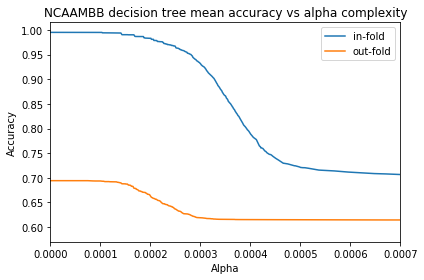

In [96]:
in_fold_c_summary = cross_validation_results.groupby('ccp_alpha')['in_fold_score'].agg(['mean']).sort_values(by = ['mean'], ascending = False)
out_fold_c_summary = cross_validation_results.groupby('ccp_alpha')['out_fold_score'].agg(['mean']).sort_values(by = ['mean'], ascending = False)
fig, ax = plt.subplots()

ax.set_xlabel("Alpha")
ax.set_ylabel("Accuracy")
ax.set_xlim(.0, .0007)
ax.set_title("NCAAMBB decision tree mean accuracy vs alpha complexity")
ax.plot(cross_validation_results["ccp_alpha"].unique(),
        in_fold_c_summary['mean'],
        label = "in-fold")
ax.plot(cross_validation_results["ccp_alpha"].unique(),
        out_fold_c_summary['mean'],
        label = "out-fold")
ax.legend()

fig.tight_layout()

### Train a final model with the optimal complexity

In [97]:
ccp_alpha_opt = 0.001944
decision_tree_model_final = DecisionTreeClassifier(criterion = 'entropy',
                                                     splitter = 'best',
                                                     max_depth = None,
                                                     min_samples_split = 2,
                                                     min_samples_leaf = 1,
                                                     min_weight_fraction_leaf = 0.0,
                                                     max_features = None,
                                                     random_state = 28,
                                                     max_leaf_nodes = None,
                                                     min_impurity_decrease = 0.0,
                                                     min_impurity_split = None,
                                                     class_weight = None,
                                                     ccp_alpha = ccp_alpha_opt)

decision_tree_model_final.fit(train_features, train_response) 

print("Decision tree accuracy on training data: ",
      decision_tree_model_final.score(train_features, train_response))
print("Decision tree accuracy on validation data: ",
      decision_tree_model_final.score(valid_features, valid_response))
print("Decision tree accuracy on test data: ",
      decision_tree_model_final.score(test_features, test_response))

Decision tree accuracy on training data:  0.7003423951157131
Decision tree accuracy on validation data:  0.720903144879491
Decision tree accuracy on test data:  0.7105048604578238


In [98]:
train_scores = [decision_tree_ccp.score(train_features, train_response) for decision_tree_ccp in decision_tree_ccps]
valid_scores = [decision_tree_ccp.score(valid_features, valid_response) for decision_tree_ccp in decision_tree_ccps]
test_scores = [decision_tree_ccp.score(test_features, test_response) for decision_tree_ccp in decision_tree_ccps]

In [99]:
print(max(train_scores))
print(max(valid_scores))
print(max(test_scores))

0.9202590652200817
0.7250246393692321
0.7155221072436501


### Function of training size

In [100]:
decision_tree_train_sizes = []
decision_tree_train_size_train_scores = []
decision_tree_train_size_test_scores = []
decision_tree_train_size_train_time = []
decision_tree_train_size_score_time = []

iter = 0
train_sizes = np.linspace(.05,.95, 19)
for train_size in train_sizes:
    (train_features_train_size, test_features_train_size,
    train_response_train_size, test_response_train_size) = train_test_split(ncaa_all_features,
                                                                            ncaa_all_response,
                                                                            train_size = train_size,
                                                                            random_state = 28)
    (train_features_train_size, test_features_train_size,
    train_response_train_size, test_response_train_size) = train_test_split(ncaa_all_features,
                                                                            ncaa_all_response,
                                                                            train_size = train_size,
                                                                            random_state = 28)
    
    iter = iter + 1
    print("iter:", iter,
          " | train size:", train_size)
    decision_tree_train_size = DecisionTreeClassifier(criterion = 'entropy',
                                                      splitter = 'best',
                                                      max_depth = None,
                                                      min_samples_split = 2,
                                                      min_samples_leaf = 1,
                                                      min_weight_fraction_leaf = 0.0,
                                                      max_features = None,
                                                      random_state = 28,
                                                      max_leaf_nodes = None,
                                                      min_impurity_decrease = 0.0,
                                                      min_impurity_split = None,
                                                      class_weight = None,
                                                      ccp_alpha = ccp_alpha_opt)
    start = time.time()
    decision_tree_train_size.fit(train_features_train_size, train_response_train_size)
    end = time.time()
    decision_tree_train_size_train_time.append(end - start)

    decision_tree_train_sizes.append(decision_tree_train_size)
    
    start = time.time()
    decision_tree_train_size_train_scores.append(decision_tree_train_size.score(train_features_train_size, train_response_train_size)) 
    end = time.time()
    decision_tree_train_size_score_time.append(end - start)

    decision_tree_train_size_test_scores.append(decision_tree_train_size.score(test_features_train_size, test_response_train_size))
    

iter: 1  | train size: 0.05
iter: 2  | train size: 0.1
iter: 3  | train size: 0.15
iter: 4  | train size: 0.2
iter: 5  | train size: 0.25
iter: 6  | train size: 0.3
iter: 7  | train size: 0.35
iter: 8  | train size: 0.39999999999999997
iter: 9  | train size: 0.44999999999999996
iter: 10  | train size: 0.49999999999999994
iter: 11  | train size: 0.5499999999999999
iter: 12  | train size: 0.6
iter: 13  | train size: 0.65
iter: 14  | train size: 0.7
iter: 15  | train size: 0.75
iter: 16  | train size: 0.7999999999999999
iter: 17  | train size: 0.85
iter: 18  | train size: 0.9
iter: 19  | train size: 0.95


### Plotting the learning curve by training size, for a fixed complexity

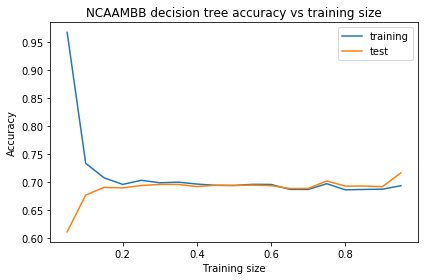

In [105]:
train_sizes = np.linspace(.05,.95, 19)

fig, ax = plt.subplots()

ax.set_xlabel("Training size")
ax.set_ylabel("Accuracy")
ax.set_title("NCAAMBB decision tree accuracy vs training size")
ax.plot(train_sizes, decision_tree_train_size_train_scores, label = "training",
        #drawstyle = "steps-post"
       )
ax.plot(train_sizes, decision_tree_train_size_test_scores, label = "test",
        #drawstyle = "steps-post"
       )
ax.legend()

fig.tight_layout()

###  Plotting the model fitting time as a function of the training size

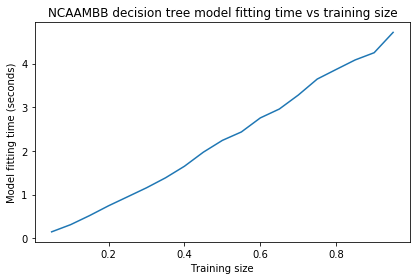

In [106]:
fig, ax = plt.subplots()

ax.set_xlabel("Training size")
ax.set_ylabel("Model fitting time (seconds)")
ax.set_title("NCAAMBB decision tree model fitting time vs training size")
ax.plot(train_sizes, decision_tree_train_size_train_time, label = "training",
        #drawstyle = "steps-post"
       )

fig.tight_layout()

### Plotting the model scoring time as a function of the training size

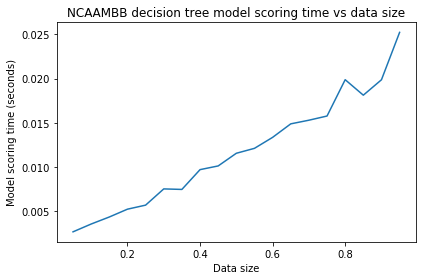

In [108]:
fig, ax = plt.subplots()

ax.set_xlabel("Data size")
ax.set_ylabel("Model scoring time (seconds)")
ax.set_title("NCAAMBB decision tree model scoring time vs data size")
ax.plot(train_sizes, decision_tree_train_size_score_time, label = "training",
        #drawstyle = "steps-post"
       )

fig.tight_layout()